In [ ]:
#import library
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#***Prepering data***

In [ ]:
facePath = "/content/drive/My Drive/ecse415/assginmentTwo/cropped_faces/"
trainfaceData = {}
testfaceData = {}
imageSet = []
tatolImg = 50*15
for i in range(1,51):
  for j in range(1,16):
    imageSet.append("s"+str(i).zfill(2)+"_"+str(j).zfill(2)+".jpg")

#print("imageSet: ",imageSet)

for i in range(int(tatolImg*0.8)):
  ranImg = random.randint(0,len(imageSet)-1)
  image = cv.imread(facePath+imageSet[ranImg])
  #print(facePath+imageSet[ranImg])
  #print("test image: ",image)
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image = cv.resize(image, (128, 192))
  if str(imageSet[ranImg][:3]) in trainfaceData.keys(): 
    trainfaceData[str(imageSet[ranImg][:3])].append(image)
  else:
    trainfaceData.update({str(imageSet[ranImg][:3]):[image]})
  imageSet.remove(imageSet[ranImg])

for i in range(len(imageSet)):
  image = cv.imread(facePath+imageSet[i])
  image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  image = cv.resize(image, (128, 192)) 
  if str(imageSet[i][:3]) in testfaceData.keys():
    testfaceData[str(imageSet[i][:3])].append(image)
  else:
    testfaceData.update({str(imageSet[i][:3]):[image]})

plot histograms

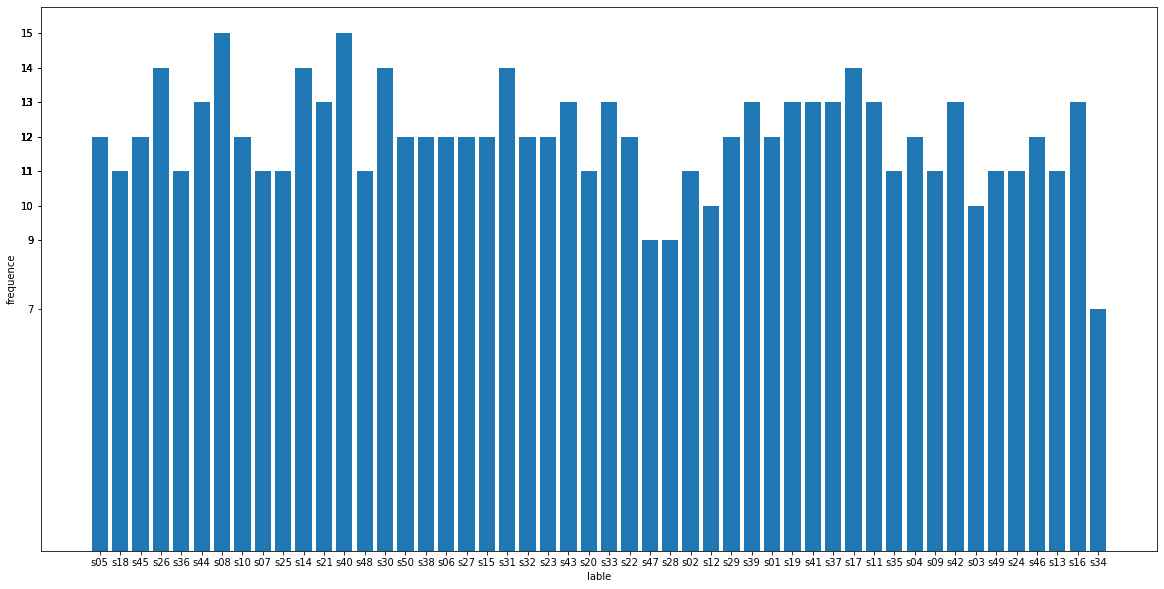

In [ ]:
num = [len(trainfaceData[key]) for key in trainfaceData.keys()]
plt.figure(figsize=(20,10))
plt.bar(list(trainfaceData.keys()),num)
plt.xticks(list(trainfaceData.keys()))
plt.yticks(num) #This may be included or excluded as per need
plt.xlabel('lable')
plt.ylabel('frequence')
plt.show()

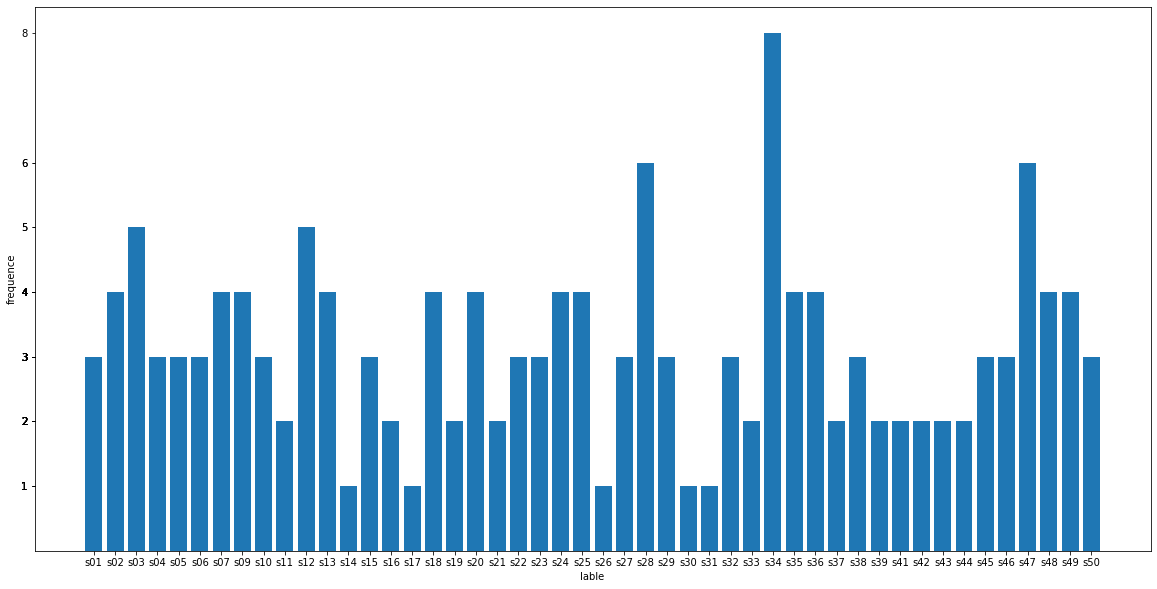

In [ ]:
num = [len(testfaceData[key]) for key in testfaceData.keys()]
plt.figure(figsize=(20,10))
plt.bar(list(testfaceData.keys()),num)
plt.xticks(list(testfaceData.keys()))
plt.yticks(num)
plt.xlabel('lable')
plt.ylabel('frequence')
plt.show()

PCA method for eigenface

In [ ]:
from functools import total_ordering
from re import M
#ref: https://www.youtube.com/watch?v=FgakZw6K1QQ
#ref: https://blog.csdn.net/qq_28888837/article/details/84672606
#ref: https://towardsdatascience.com/principal-component-analysis-pca-from-scratch-in-python-7f3e2a540c51
def PCA(X_T:np.array):
  #Input loading training set face, into an M row N column matrix T
  #make sure the features are allien using stander scaler
  #X_T_scaled = StandardScaler().fit_transform(X_T)
  X_T_scaled = X_T
  #find Mean value for X _T by 0
  mean = X_T_scaled.mean(axis = 0)
  A = X_T_scaled - mean
  #print("A: ",A.shape)
  V = np.cov(A)
  #print("V: ",V.shape)
  values, vectors = np.linalg.eig(V)
  V = A.T @ vectors
  #values = A.T @ values
  #print("vector: ",V)
  # normalizedVector = np.empty_like(V)
  # print("normalizedVector: ", normalizedVector.shape)
  # print(tatolImg)
  #divide vectors and make the magnitute unite one
  # unitOne = np.linalg.norm(V, axis=0)
  # for i in range(X_T.shape[0]):
  #   normalizedVector[:,i] = V[:,i] / unitOne[i]
  #ref: https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
  #sort values and vectors in accending order
  idx = np.argsort(values)[::-1]
  values = values[idx]
  V = V[:,idx]
  w = ((V.T)@(A.T))
  #weights = A.T * normalizedVector
  return V, values, w.T,mean#return the list in decending order

plotting

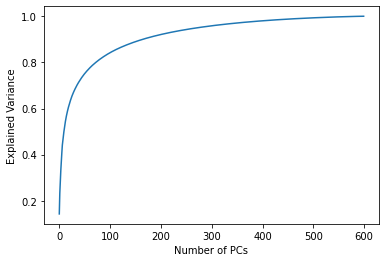

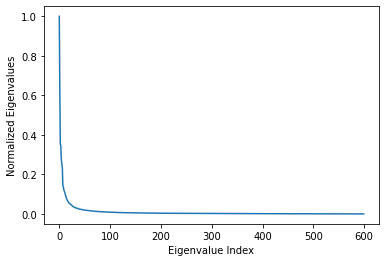

In [ ]:
from numpy.core.fromnumeric import shape
imgFlatted = []
for keys in list(trainfaceData.keys()):
  for img in trainfaceData[keys]:
    imgFlatted.append(img.flatten())
imgFlatted = np.array(imgFlatted)

vectors, values ,w, m= PCA(imgFlatted)

#Variance ratio
plt.figure()
plt.plot(np.cumsum(values) / np.sum(values))
plt.xlabel("Number of PCs")
plt.ylabel("Explained Variance")
plt.show()

#Normalized eigenvalues
normEigenvalues = values / np.max(values)
plt.figure()
plt.plot(normEigenvalues)
plt.xlabel("Eigenvalue Index")
plt.ylabel("Normalized Eigenvalues")
plt.show()

a huge amount of eigen vector can cuase overfitting, thereforem we need to reduce the sample size of eigen vector. futhermore, if we want to represent image data set more accurately. we don't need large number amount of vecotr. we just need to choose the best vector and eliminate large scale of vectors and still have good representation


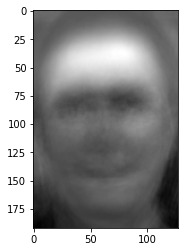

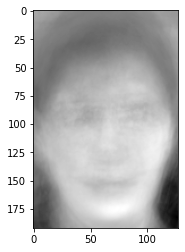

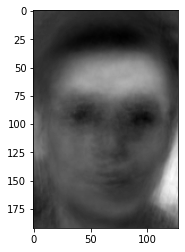

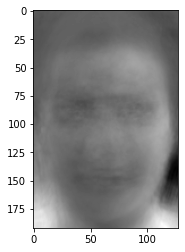

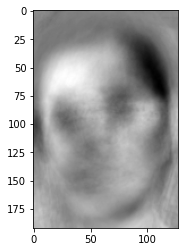

In [ ]:
faces = vectors.T
# plt.figure(figsize=(15,15))
plt.imshow(np.reshape(faces[0], (192,128)), cmap='gray')
plt.show()
plt.imshow(np.reshape(faces[1], (192,128)), cmap='gray')
plt.show()
plt.imshow(np.reshape(faces[2], (192,128)), cmap='gray')
plt.show()
plt.imshow(np.reshape(faces[3], (192,128)), cmap='gray')
plt.show()
plt.imshow(np.reshape(faces[4], (192,128)), cmap='gray')
plt.show()

classification

In [ ]:
trainList = []
testList = []
test_T = []
for keys in list(trainfaceData.keys()):
  for img in trainfaceData[keys]:
    trainList.append(keys)
for keys in list(testfaceData.keys()):
  for img in testfaceData[keys]:
    testList.append(keys)
for keys in list(testfaceData.keys()):
  for img in testfaceData[keys]:
    test_T.append(img.flatten())
test_T = np.array(test_T)
test_W = (test_T-m)@vectors

find the nearest neighbour in the training set (L2 distance)

In [ ]:
#ref: https://github.com/allanreuben/ECSE415/blob/master/Assignment%203%20Face%20Detection%20%26%20Classification.ipynb
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
clf = KNeighborsClassifier(n_neighbors=1,metric='l2')
clf.fit(w, trainList)
pred = clf.predict(test_W)
accuracy = metrics.accuracy_score(testList, pred)*100
print("Accuracy:",metrics.accuracy_score(testList, pred)*100,"%")

Accuracy: 69.33333333333334 %


Linear SVM classifier

In [ ]:
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
clf = svm.SVC(kernel="linear")
# print(w.shape)
# print(len(trainList))
clf.fit(w, trainList)
svm_pred = clf.predict(test_W)
svm_accuracy = metrics.accuracy_score(testList, svm_pred)*100
print(f'accuracy: ' + str(svm_accuracy) + "%")
matrix = metrics.confusion_matrix(testList, svm_pred)
print("accuracy pre class")
print(matrix.diagonal()/matrix.sum(axis=1))


accuracy: 82.0%
accuracy pre class
[0.66666667 1.         1.         1.         0.66666667 1.
 0.75              nan 0.5        0.66666667 1.         1.
 0.5        0.         1.         0.         1.         0.5
 1.         1.         1.         1.         1.         1.
 1.         1.         0.33333333 1.         1.         1.
 1.         1.         0.5        0.5        0.75       1.
 1.         1.         0.5               nan 0.         1.
 1.         0.5        1.         0.66666667 1.         0.75
 1.         1.        ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


as we can see from the accuracy pre class result and compare with the histogram. We can calculate that more training image a class has, more accurate the class recognization will be.

RBF SVM classifier

In [ ]:
#ref: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(kernel="rbf")
# print(w.shape)
# print(len(trainList))
clf.fit(w, trainList)
svm_pred = clf.predict(test_W)
svm_accuracy = metrics.accuracy_score(testList, svm_pred)*100
print(f'accuracy: ' + str(svm_accuracy) + "%")

accuracy: 55.333333333333336%


Random Forest Classifier

In [ ]:
#ref: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(w, trainList)
#rint(w.shape)
# for i in range(len(testList)):
#   testList[i] = i
y_pred=clf.predict(test_W)
print("Accuracy:",metrics.accuracy_score(testList, y_pred)*100,"%")

Accuracy: 53.333333333333336 %


the accuracy change every time due to over fitting

PCA algorithm

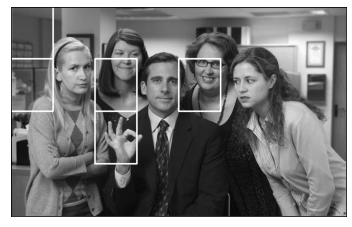

In [ ]:
#ref: https://www.geeksforgeeks.org/ml-face-recognition-using-pca-implementation/
path = "/content/drive/My Drive/ecse415/assginmentTwo/"
from numpy.linalg.linalg import norm
def detectFace(img):
  img_w = faces @ (img-m).T
  dis = (np.linalg.norm(w-img_w))
  return int(dis/10000000)
img = cv.imread(path +'/group_image.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
def slipImg(img):
  result = []
  for i in range(4):
    for j in range(8):
      foo = img[i*100:(i+1)*100,j*80:(j+1)*80]
      result.append(cv.resize(np.float32(foo),(128,192)))
  return result
testImg = slipImg(img)
result = []
for i in range(len(testImg)):
  dis = detectFace(testImg[i].flatten())
  #print(dis)
  if(dis<900):
    result.append(i)
#print(result)
for ele in result:
    img = cv.rectangle(img,((int(ele%8))*80,(int(ele/8))*100),((int(ele%8))*80+80,(int(ele/8)*100)+100),(255,0,0),2)
    #gray = cv.rectangle(img,((int(ele/8))*80,(int(ele%8))*100),((int(ele/8))+80,(int(ele%8))*100+100),(255,0,0),2)
plt.imshow(img, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()

PCA Algorithm has 2 true positive,5 flase positive and 2 false negative.

Viola Jones algorithm

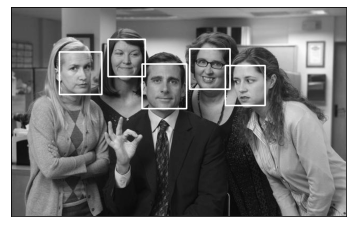

In [ ]:
#ref: tutorial 5
path = "/content/drive/My Drive/ecse415/assginmentTwo/"
face_cascade = cv.CascadeClassifier(path+'haarcascade_frontalface_default.xml')
img = cv.imread(path+'group_image.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3,4)#change parameter to match
for (x,y,w,h) in faces:
    gray = cv.rectangle(gray,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(gray, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()

Viola jones Algorithm has 5 true positive and 0 false negative. I assume it works better than PCA detector when it comes to face recognization

HoG algorithm

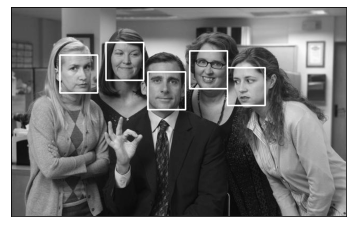

In [ ]:
import dlib as bd
detector = bd.get_frontal_face_detector()
img = cv.imread(path +'/group_image.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
faces = detector(gray)
for i in range(5):
  gray = cv.rectangle(gray,(faces[i].left(),faces[i].top()),(faces[i].right(),faces[i].bottom()),(255,0,0),2)
plt.figure()
plt.imshow(gray,cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()

HoG Algorithm has 5 true positive and 0 false negative. the face recognization quolity is similar to the Viola jones.

By comparsion and experimenting, I discover that when the face are a lot and not too clear, the viola jones alhorithm is not able to distingust the other object and face very will. and HoG works very well in every image i test on. But HoG is not a machine learning algorithm, it detect the feature of human face, therefore, I argue that it will not work well when we use HoG to label the different faces, but PCA is able to do that 